In [1]:
%%configure -f
{
    "conf": {
        "spark.pyspark.python": "python3",
        "spark.pyspark.virtualenv.enabled": "true",
        "spark.pyspark.virtualenv.type":"native",
        "spark.pyspark.virtualenv.bin.path":"/usr/bin/virtualenv"
    }
}

### Install packages

In [2]:
sc.install_pypi_package("boto3==1.19.2")
sc.install_pypi_package("pandas==1.0.5")
sc.install_pypi_package("scipy==1.4.1")
sc.install_pypi_package("matplotlib==3.2.1")
sc.install_pypi_package("seaborn==0.10.1")
sc.install_pypi_package("textblob")
sc.install_pypi_package("pyspellchecker")

Starting Spark application


ID,YARN Application ID,Kind,State,Spark UI,Driver log,Current session?
0,application_1685064596730_0002,pyspark,idle,Link,Link,✔


FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

SparkSession available as 'spark'.


FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

### Load dataset

In [4]:
df = spark.read.parquet('s3://amazon-reviews-pds/parquet/product_category=Electronics/*.parquet')

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [5]:
print(df.count())

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

3120938

### Data Cleaning

In [6]:
# Drop NA
df = df.na.drop()
print(df.count())

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

3120848

#### Response variable (Y) 

In [7]:
df = df.withColumn('vp_dummy', 
                             (df.verified_purchase == 'Y').cast("integer"))

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [8]:
df.groupBy('vp_dummy').count().show()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+--------+-------+
|vp_dummy|  count|
+--------+-------+
|       1|2622841|
|       0| 498007|
+--------+-------+

In [9]:
vp = df[df.vp_dummy == 1].count()
nvp = df[df.vp_dummy == 0].count()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

### Balance dataset

In [10]:
from pyspark.sql.functions import col
df = df.sampleBy("vp_dummy", fractions={0:1,1:nvp/vp}, seed=0)
df.groupBy("vp_dummy").count().orderBy("vp_dummy").show()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+--------+------+
|vp_dummy| count|
+--------+------+
|       0|498007|
|       1|497877|
+--------+------+

In [10]:
df.columns

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

['marketplace', 'customer_id', 'review_id', 'product_id', 'product_parent', 'product_title', 'star_rating', 'helpful_votes', 'total_votes', 'vine', 'verified_purchase', 'review_headline', 'review_body', 'review_date', 'year', 'vp_dummy']

### Feature engineering

#### 1. spelling_errors

In [11]:
from pyspark.sql.functions import udf
from pyspark.sql.types import IntegerType
from spellchecker import SpellChecker
import string

# Assuming you have a DataFrame 'df' with a 'review' column

spell = SpellChecker()

def spelling_errors(text):
    if text is None:
        return None
    text = text.lower()
    text = text.translate(str.maketrans('', '', string.punctuation))
    misspelled = spell.unknown(text.split())
    return len(misspelled)

count_errors_udf = udf(spelling_errors, IntegerType())

# Apply the UDF to the 'review' column
df = df.withColumn("spelling_errors", count_errors_udf(df['review_body']))


FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

#### 2. sentiment_score

In [12]:
from textblob import TextBlob
from pyspark.sql.types import FloatType
from pyspark.sql.functions import udf

# Define a UDF to calculate sentiment polarity
def sentiment_analysis(text):
    return TextBlob(text).sentiment.polarity

sentiment_analysis_udf = udf(sentiment_analysis, FloatType())

# Apply the UDF to the 'review' column
df = df.withColumn("sentiment_score", sentiment_analysis_udf(df['review_body']))


FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

#### 3. helpful_pct

In [13]:
# Create helpful_pct
df = df.withColumn('helpful_pct', 
                             (df.helpful_votes / df.total_votes)).fillna(0)


FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

#### 4. review_length

In [14]:
import pyspark.sql.functions as F
from pyspark.ml.feature import VectorAssembler
from pyspark.sql.window import Window

# Length of Review
df = df.withColumn('review_length', F.length("review_body"))
# 1. categorical vine and verified_purchase
df = df.withColumn('v_dummy', 
                             (df.vine == 'Y').cast("integer"))


FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

#### 5. marketplace

In [15]:
### one-hot encoding "marketplace" variable
from pyspark.ml.feature import StringIndexer, OneHotEncoder
from pyspark.ml import Pipeline

# First index the string column
indexer = StringIndexer(inputCol="marketplace", outputCol="marketplaceIndex")

# Then encode the indexed values to dummy variables
encoder = OneHotEncoder(inputCol="marketplaceIndex", outputCol="marketplaceVec")

# Create a pipeline to apply the transformations
pipeline = Pipeline(stages=[indexer, encoder])

# Fit and transform the data
df= pipeline.fit(df).transform(df)

df.show()


FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+-----------+-----------+--------------+----------+--------------+--------------------+-----------+-------------+-----------+----+-----------------+--------------------+--------------------+-----------+----+--------+---------------+---------------+------------------+-------------+-------+----------------+--------------+
|marketplace|customer_id|     review_id|product_id|product_parent|       product_title|star_rating|helpful_votes|total_votes|vine|verified_purchase|     review_headline|         review_body|review_date|year|vp_dummy|spelling_errors|sentiment_score|       helpful_pct|review_length|v_dummy|marketplaceIndex|marketplaceVec|
+-----------+-----------+--------------+----------+--------------+--------------------+-----------+-------------+-----------+----+-----------------+--------------------+--------------------+-----------+----+--------+---------------+---------------+------------------+-------------+-------+----------------+--------------+
|         US|   51163966|R2RX7KLOQ

In [16]:
df.columns

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

['marketplace', 'customer_id', 'review_id', 'product_id', 'product_parent', 'product_title', 'star_rating', 'helpful_votes', 'total_votes', 'vine', 'verified_purchase', 'review_headline', 'review_body', 'review_date', 'year', 'vp_dummy', 'spelling_errors', 'sentiment_score', 'helpful_pct', 'review_length', 'v_dummy', 'marketplaceIndex', 'marketplaceVec']

In [17]:
from pyspark.ml.feature import VectorAssembler
from pyspark.ml import Pipeline
from pyspark.ml.classification import LinearSVC
from pyspark.sql.functions import regexp_replace

#selected features 
vector_assembler = VectorAssembler(inputCols=['marketplaceVec',
                                              'review_length',
                                              'v_dummy',
                                              'star_rating',
                                            'sentiment_score',
                                              'spelling_errors',
                                            'helpful_pct'],
                                   outputCol='features')


FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

## SVC model

In [ ]:
# Create a SVC model
lsvc = LinearSVC(featuresCol='features',labelCol='vp_dummy')
pipeline = Pipeline(stages=[vector_assembler, lsvc])


In [22]:
# Reduce and split data
sampled_data = df.sample(fraction = 0.001)
train, test = sampled_data.randomSplit([0.7, 0.3])


FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [16]:
# Create an evaluator 
from pyspark.ml.evaluation import BinaryClassificationEvaluator

evaluator = BinaryClassificationEvaluator(labelCol='vp_dummy', metricName='areaUnderROC')


FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [17]:
# Create a grid of tuning the parameters 
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
import numpy as np 

params = ParamGridBuilder() \
    .addGrid(lsvc.maxIter, [10, 50, 100]) \
    .addGrid(lsvc.regParam, [0.1, 0.01, 0.001]) \
    .build()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [18]:
# Create cross validator
cv = CrossValidator(estimator = pipeline,
                    estimatorParamMaps = params,
                    evaluator = evaluator)

# Fit the cross validator
model = cv.setNumFolds(5).fit(train)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [19]:
# Get the best model from cross-validation
bestModel = model.bestModel

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [20]:
# Print the best parameters
bestParams = bestModel.stages[-1].extractParamMap()
print("Best Parameters:")
for param, value in bestParams.items():
    print(f"{param.name}: {value}")

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Best Parameters:
aggregationDepth: 2
featuresCol: features
fitIntercept: True
labelCol: vp_dummy
maxIter: 50
predictionCol: prediction
rawPredictionCol: rawPrediction
regParam: 0.001
standardization: True
threshold: 0.0
tol: 1e-06

- The best maxIter: 50
- The best regParam: 0.001


### AUC

In [21]:
# Evaluate the model on the test data
predictions = bestModel.transform(test)
binaryAUC = evaluator.evaluate(predictions)


FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [57]:
predictions.show()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+-----------+-----------+--------------+----------+--------------+--------------------+-----------+-------------+-----------+----+-----------------+--------------------+--------------------+-----------+----+--------+---------------+---------------+------------------+-------------+-------+----------------+--------------+--------------------+--------------------+----------+
|marketplace|customer_id|     review_id|product_id|product_parent|       product_title|star_rating|helpful_votes|total_votes|vine|verified_purchase|     review_headline|         review_body|review_date|year|vp_dummy|spelling_errors|sentiment_score|       helpful_pct|review_length|v_dummy|marketplaceIndex|marketplaceVec|            features|       rawPrediction|prediction|
+-----------+-----------+--------------+----------+--------------+--------------------+-----------+-------------+-----------+----+-----------------+--------------------+--------------------+-----------+----+--------+---------------+---------------+--

In [33]:
# Print the Area Under ROC Curve (AUC) value
print("Test AUC: {:.4f}".format(binaryAUC))

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Test AUC: 0.6982

In [35]:
# Train AUC
train_predictions = bestModel.transform(train)
train_binaryAUC = evaluator.evaluate(train_predictions)
print("Train AUC: {:.4f}".format(train_binaryAUC))

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Train AUC: 0.6662

### Accuracy score

In [37]:
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

# Evaluate the model using the evaluator (test accuracy)
acc_evaluator = MulticlassClassificationEvaluator(labelCol='vp_dummy', metricName='accuracy')
test_accuracy = acc_evaluator.evaluate(predictions)
print("Test accuracy: {:.4f}".format(test_accuracy))


FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Test accuracy: 0.6460

In [32]:
# Evaluate the model using the evaluator (train accuracy)
acc_evaluator = MulticlassClassificationEvaluator(labelCol='vp_dummy', metricName='accuracy')
train_accuracy = acc_evaluator.evaluate(train_predictions)

print("Train accuracy: {:.4f}".format(train_accuracy))


FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Train accuracy: 0.6662

### F1 score

In [31]:
# Evaluate the model using the evaluator (f1)
f1_evaluator = MulticlassClassificationEvaluator(labelCol='vp_dummy', metricName='f1')
f1 = f1_evaluator.evaluate(predictions)


FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [38]:
print("Test F1: {:.4f}".format(f1))

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Test F1: 0.6383

In [39]:
train_f1 = f1_evaluator.evaluate(train_predictions)
print("Train F1: {:.4f}".format(train_f1))

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Train F1: 0.6083

### Plot ROC curve

In [41]:
raw_predictions = predictions.select('vp_dummy', 'rawPrediction')

# Convert the raw prediction values to (probability, label) tuples:
convert_predictions = raw_predictions.rdd.map(lambda row: (float(row['rawPrediction'][1]), float(row['vp_dummy'])))

# Sort the predictions by probability in descending order
sorted_predictions = convert_predictions.sortBy(lambda x: x[0], ascending=False)

# Count the positive and negative instances in the test data
total_positive = sorted_predictions.filter(lambda x: x[1] == 1.0).count()
total_negative = sorted_predictions.filter(lambda x: x[1] == 0.0).count()


# Initialize variables to store the true positive rate (TPR) and false positive rate (FPR)
tpr_values = []
fpr_values = []
tp = 0
fp = 0

# Compute TPR and FPR at different probability thresholds
for prob, label in sorted_predictions.collect():
    if label == 1.0:
        tp += 1
    else:
        fp += 1
    tpr = tp / total_positive
    fpr = fp / total_negative
    tpr_values.append(tpr)
    fpr_values.append(fpr)


FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

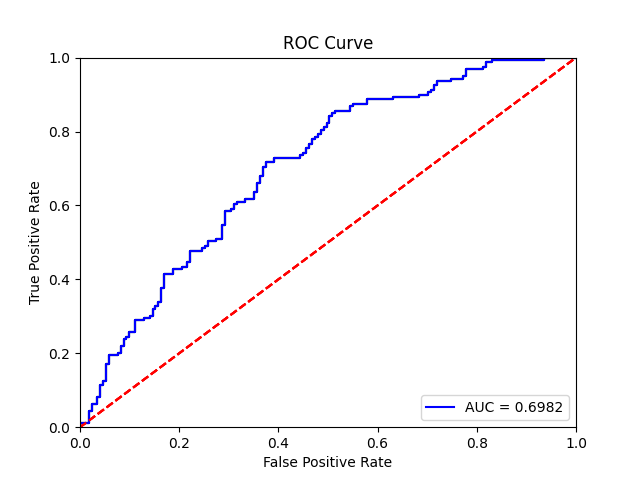

In [40]:
import matplotlib.pyplot as plt

# Plot the ROC curve
plt.plot(fpr_values, tpr_values, 'b', label = 'AUC = 0.6982')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.legend(loc = 'lower right')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()

%matplot plt

### Confusion matrix

In [59]:
confusion_matrix = predictions.groupBy('vp_dummy', 'prediction').count().orderBy('vp_dummy', 'prediction')
confusion_matrix.show()


FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+--------+----------+-----+
|vp_dummy|prediction|count|
+--------+----------+-----+
|       0|       0.0|   80|
|       0|       1.0|   80|
|       1|       0.0|   34|
|       1|       1.0|  128|
+--------+----------+-----+

## DecisionTreeClassifier 

In [23]:
from pyspark.ml.classification import DecisionTreeClassifier
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
import numpy as np 
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
evaluator = BinaryClassificationEvaluator(labelCol='vp_dummy', metricName='areaUnderROC')

decision_tree = DecisionTreeClassifier(labelCol='vp_dummy',
                                       featuresCol='features')
pipeline_dt = Pipeline(stages=[vector_assembler, decision_tree])

param_grid = ParamGridBuilder() \
    .addGrid(decision_tree.maxDepth, [2, 5, 10]) \
    .addGrid(decision_tree.impurity, ["gini", "entropy"]) \
    .addGrid(decision_tree.minInstancesPerNode, [1, 10, 100]) \
    .build()

# evaluator 
evaluator = BinaryClassificationEvaluator(labelCol='vp_dummy', metricName='areaUnderROC')

cross_validator = CrossValidator(estimator=pipeline_dt,
                                estimatorParamMaps=param_grid,
                                evaluator=evaluator,
                                numFolds=5)
cv_model = cross_validator.fit(train)


FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [24]:
# Get the best model from cross-validation
dt_bestModel = cv_model.bestModel

# Print the best parameters
dt_bestParams = dt_bestModel.stages[-1].extractParamMap()
print("Best Parameters:")
for dt_param, dt_value in dt_bestParams.items():
    print(f"{dt_param.name}: {dt_value}")

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Best Parameters:
cacheNodeIds: False
checkpointInterval: 10
featuresCol: features
impurity: entropy
labelCol: vp_dummy
leafCol: 
maxBins: 32
maxDepth: 5
maxMemoryInMB: 256
minInfoGain: 0.0
minInstancesPerNode: 1
minWeightFractionPerNode: 0.0
predictionCol: prediction
probabilityCol: probability
rawPredictionCol: rawPrediction
seed: 956191873026065186

In [26]:
# Evaluate the model on the test data
dt_predictions = dt_bestModel.transform(test)
dt_binaryAUC = evaluator.evaluate(dt_predictions)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

### AUC Score

In [27]:
# Print the Area Under ROC Curve (AUC) value
print("Test AUC: {:.4f}".format(dt_binaryAUC))

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Test AUC: 0.7348

In [29]:
# Train AUC
dt_train_predictions = dt_bestModel.transform(train)
dt_train_binaryAUC = evaluator.evaluate(dt_train_predictions)
print("Train AUC: {:.4f}".format(dt_train_binaryAUC))

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Train AUC: 0.7176

### Accuracy Score

In [30]:
# Evaluate the model using the evaluator (test accuracy)
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
dt_acc_evaluator = MulticlassClassificationEvaluator(labelCol='vp_dummy', metricName='accuracy')
dt_test_accuracy = dt_acc_evaluator.evaluate(dt_predictions)
print("Test accuracy: {:.4f}".format(dt_test_accuracy))



FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Test accuracy: 0.6465

In [59]:
# Evaluate the model using the evaluator (train accuracy)
dt_acc_evaluator = MulticlassClassificationEvaluator(labelCol='vp_dummy', metricName='accuracy')
dt_train_accuracy = dt_acc_evaluator.evaluate(dt_train_predictions)

print("Train accuracy: {:.4f}".format(dt_train_accuracy))


FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Train accuracy: 0.6776

### Plot ROC curve

In [31]:
dt_raw_predictions = dt_predictions.select('vp_dummy', 'rawPrediction')

# Convert the raw prediction values to (probability, label) tuples:
dt_convert_predictions = dt_raw_predictions.rdd.map(lambda row: (float(row['rawPrediction'][1]), float(row['vp_dummy'])))

# Sort the predictions by probability in descending order
dt_sorted_predictions = dt_convert_predictions.sortBy(lambda x: x[0], ascending=False)

# Count the positive and negative instances in the test data
dt_total_positive = dt_sorted_predictions.filter(lambda x: x[1] == 1.0).count()
dt_total_negative = dt_sorted_predictions.filter(lambda x: x[1] == 0.0).count()


# Initialize variables to store the true positive rate (TPR) and false positive rate (FPR)
dt_tpr_values = []
dt_fpr_values = []
dt_tp = 0
dt_fp = 0

# Compute TPR and FPR at different probability thresholds
for dt_prob, dt_label in dt_sorted_predictions.collect():
    if dt_label == 1.0:
        dt_tp += 1
    else:
        dt_fp += 1
    dt_tpr = dt_tp / dt_total_positive
    dt_fpr = dt_fp / dt_total_negative
    dt_tpr_values.append(dt_tpr)
    dt_fpr_values.append(dt_fpr)


FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

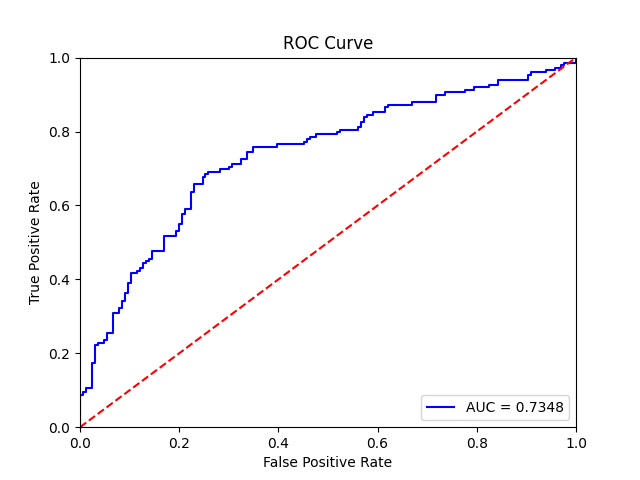

In [34]:
import matplotlib.pyplot as plt

# Plot the ROC curve
plt.plot(dt_fpr_values, dt_tpr_values, 'b', label = 'AUC = 0.7348')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.legend(loc = 'lower right')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()

%matplot plt